### Display Feature Layer

In [1]:
from IPython.display import display
import arcgis
from arcgis import *
from arcgis.geometry import Geometry

import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from numpy import mean
import statistics
import fiona
import json
import shapely
from shapely.geometry import shape, Point
from shapely.geometry import mapping, Polygon

import pyproj
from shapely.ops import transform
from functools import partial

import warnings
warnings.filterwarnings('ignore')


### Input parameters

In [2]:
# Set which year to query
query_year = '2012'

# pass input shape location
inp_shp = 'NeighborhoodCouncils_4326.geojson'

# cooridnate system of the input shape. It must be epsg:4326
inp_crs = 'epsg:4326'

### Make connection to ArcGIS online

In [3]:
# connect to your GIS without signing in
gis = GIS("https://www.arcgis.com")

In [4]:
webmap_search = gis.content.search("prediction_LA_cnty_LA_cnty_2009", item_type="Feature Layer", max_items = 100,outside_org=True)
LA_map_item = webmap_search[0]
LA_layer_2009 = LA_map_item.layers[0]

webmap_search = gis.content.search("prediction_LA_cnty_LA_cnty_2012", item_type="Feature Layer", max_items = 100,outside_org=True)
LA_map_item = webmap_search[0]
LA_layer_2012 = LA_map_item.layers[0]

webmap_search = gis.content.search("LA_cnty_2014", item_type="Feature Layer", max_items = 100,outside_org=True)
LA_map_item = webmap_search[0]
LA_layer_2014 = LA_map_item.layers[0]

webmap_search = gis.content.search("LA_cnty_2016", item_type="Feature Layer", max_items = 100,outside_org=True)
LA_map_item = webmap_search[0]
LA_layer_2016 = LA_map_item.layers[0]

webmap_search = gis.content.search("LA_cnty_2018", item_type="Feature Layer", max_items = 100,outside_org=True)
LA_map_item = webmap_search[0]
LA_layer_2018 = LA_map_item.layers[0]

In [5]:
if query_year == '2009':
    LA_layer = LA_layer_2009
elif query_year == '2012':
    LA_layer = LA_layer_2012
elif query_year == '2014':
    LA_layer = LA_layer_2014
elif query_year == '2016':
    LA_layer = LA_layer_2016
elif query_year == '2018':
    LA_layer = LA_layer_2018

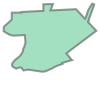

In [6]:
with open(inp_shp) as f:
    js = json.load(f)

arg_list = js['features']
geom =  arg_list[10]['geometry']
s = shape(geom)
geom = Geometry(geom)
geom

In [7]:
proj = partial(pyproj.transform, pyproj.Proj(init=inp_crs),
               pyproj.Proj(init='epsg:32611'))

s_new = transform(proj, s)

projected_area = transform(proj, s).area
projected_area_sqm = projected_area*3.86102e-7 # convert to square miles
print('Total area of the given geometry in square miles= ',projected_area_sqm)

Total area of the given geometry in square miles=  10.471268200915066


In [8]:
aoi = arcgis.geometry.filters.intersects(geom)

In [9]:
# query a feature layer for features that meet filter criteria
queried_layer = LA_layer.query(geometry_filter=aoi)

In [10]:
df = queried_layer.sdf
df

,FID,Scored_Lab,roof_no,bld_id,shp_area,Shape__Area,Shape__Length,SHAPE
0,725038,0.141404,739188,488700740025,29.450964,42.726562,28.036702,"{'rings': [[[-13162430.4079709, 3998423.716908..."
1,725102,0.135888,739189,491918743286,17.049961,24.746094,22.355461,"{'rings': [[[-13161248.3122178, 3999629.520156..."
2,725142,0.178645,739190,490626743490,29.081503,42.199219,32.363510,"{'rings': [[[-13161728.6251034, 3999708.694710..."
3,725168,0.131271,739191,493137743784,802.871167,1165.097656,134.907883,"{'rings': [[[-13160828.4864411, 3999827.143253..."
4,725200,0.175920,739192,492510744998,2169.712574,3148.882812,305.511072,"{'rings': [[[-13161015.9104557, 4000290.400934..."
...,...,...,...,...,...,...,...,...
19280,3137458,0.127720,3118016,474690747801,136.408857,198.007812,62.054372,"{'rings': [[[-13167556.1036857, 4001270.275642..."
19281,3137627,0.151054,3114711,473747747442,86.638359,125.757812,47.195259,"{'rings': [[[-13167914.8278725, 4001130.597579..."
19282,3138653,0.178960,3114679,488575741280,8.488818,12.316406,14.134987,"{'rings': [[[-13162472.7734963, 3998887.247069..."
19283,3138811,0.142058,3117999,489817742256,11.917653,17.292969,14.863633,"{'rings': [[[-13162021.1742956, 3999245.671085..."


In [11]:
if query_year == '2009' or '2012':
    df.rename(columns={'Scored_Lab': 'albedo','shp_area': 'shape_area'}, inplace=True)

match_area = df['shape_area'].sum(axis=0)

In [12]:
# functions for percentage calculation and histogram

def percentage(part, whole):
  return 100 * float(part)/float(whole)

def plot_histogram(dataframe):
    dataframe['ScoredLabels']=dataframe['albedo']
    x = dataframe.ScoredLabels.dropna()
    plt.figure(figsize=(9,9))
    N, bins, patches = plt.hist(x,bins=[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 
                                    0.8, 0.85,0.9,0.95,1])

    cmap = plt.get_cmap('jet')
    low = cmap(0.5)
    medium =cmap(0.2)
    high = cmap(0.7)


    for i in range(0,1):
        patches[i].set_facecolor('#d7191c')
    for i in range(1,2):
        patches[i].set_facecolor('#e9603d')
    for i in range(2,3):
        patches[i].set_facecolor('#fca75d')
    for i in range(3,4):
        patches[i].set_facecolor('#fed189')
    for i in range(4,5):
        patches[i].set_facecolor('#fff8b6')
    for i in range(5,6):
        patches[i].set_facecolor('#eef8c8')
    for i in range(6,7):
        patches[i].set_facecolor('#d9eed3')
    for i in range(7,8):
        patches[i].set_facecolor('#c3e4dd')
    for i in range(8,9):
        patches[i].set_facecolor('#addae8')
    for i in range(9,10):
        patches[i].set_facecolor('#85b9d2')
    for i in range(10,11):
        patches[i].set_facecolor('#5a96b8')
    for i in range(11,12):
        patches[i].set_facecolor('#2f729d')
    for i in range(12,18):
        patches[i].set_facecolor('#054e83')

    plt.grid()    
    plt.xlabel("Predicted Albedo", fontsize=16)  
    plt.ylabel("Count of Roofs", fontsize=16)
    plt.axvline(x.mean(), color='#544f50', linestyle='dashed', linewidth=1)
    plt.xticks(np.arange(0, 1.01, 0.05),fontsize=8)   

    ax = plt.subplot(111)  

    mu = round(dataframe.loc[:,"albedo"].mean(),4)
    sigma = round(dataframe.loc[:,"albedo"].std(),4)
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (mu, ),
        r'$\sigma=%.2f$' % (sigma, )))
    plt.text(1, 1, textstr, verticalalignment='top', horizontalalignment='right',transform=ax.transAxes, style='italic',fontsize=8)

    plt.show()


In [13]:
# list of small, medium and large roof areas
small_roofs = df.loc[(df['shape_area'] <= 500)]
s_rfs_ar = small_roofs['shape_area'].sum(axis=0)

medium_roofs = df.loc[(df['shape_area'] > 500) & (df['shape_area'] <= 5000)]
m_rfs_ar = medium_roofs['shape_area'].sum(axis=0)

large_roofs = df.loc[(df['shape_area'] >= 5000)]
l_rfs_ar = large_roofs['shape_area'].sum(axis=0)

# find the count of small and large roofs 
cnt_small_roofs = len(small_roofs)
cnt_medium_roofs = len(medium_roofs)
cnt_large_roofs = len(large_roofs)

### Summary Statistics

Total area of the given geometry =  27120471.28 square meters
Total area of roofs within the given geometry =  3120687.29 square meters
Total count of roofs within the given geometry =  19285

number of small roofs =  18505
Total area of small roofs =  2017506.07 square meters
Percentage of small roofs on total area =  64.65 %

number of medium roofs =  755
Total area of medium roofs =  822460.03 square meters
Percentage of medium roofs on total area =  26.36 %

number of large roofs =  25
Total area of large roofs =  280721.19 square meters
Percentage of large roofs on total area =  9.0 %

Histogram of albedos for all roofs in 2012 within the AOI


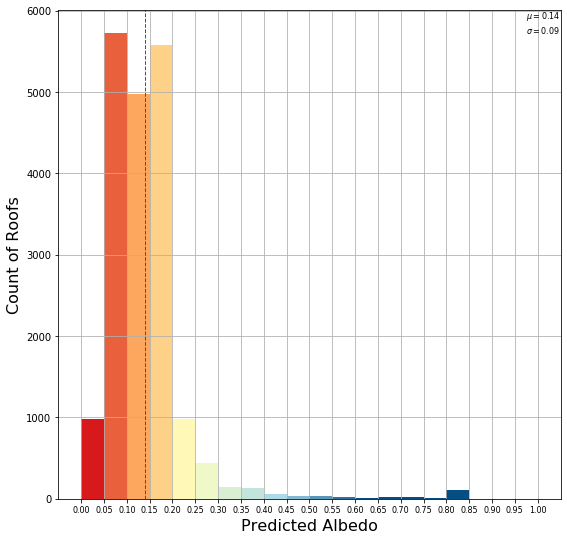

Histogram of albedos for small roofs in 2012 within the AOI


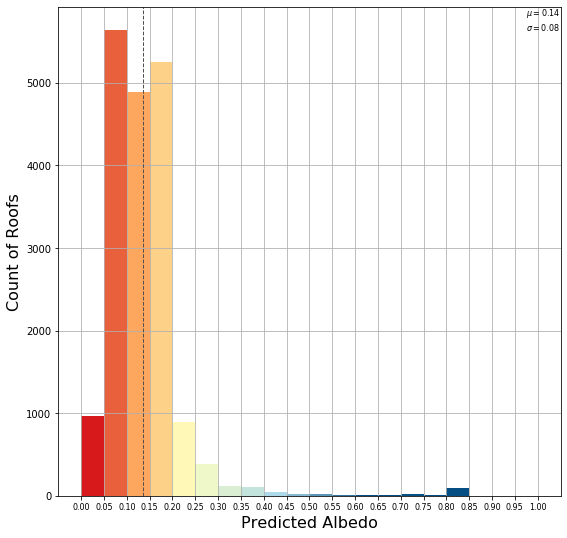

Histogram of albedos for medium roofs in 2012 within the AOI


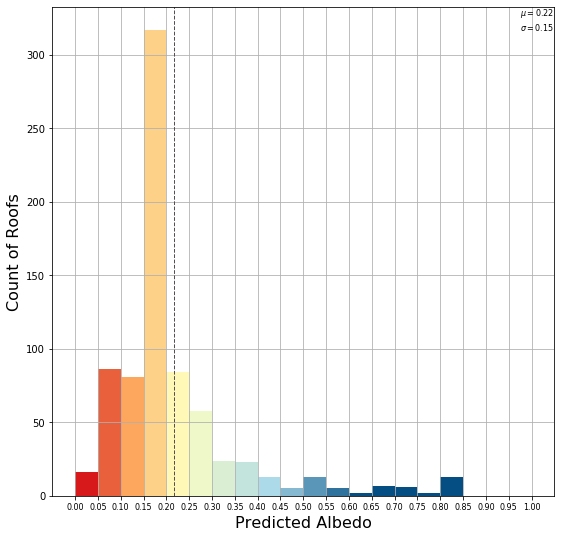

Histogram of albedos for large roofs in 2012 within the AOI


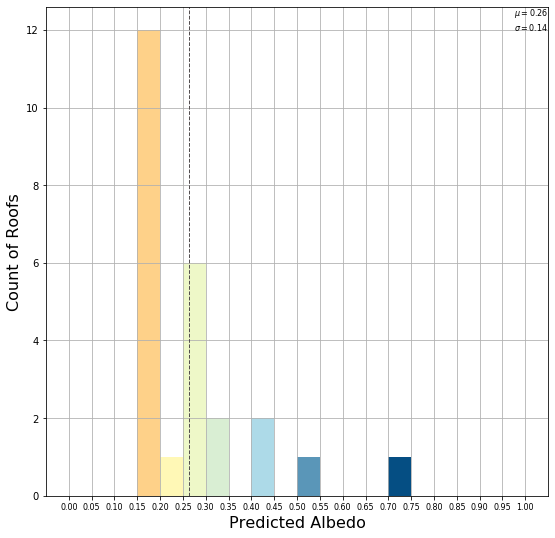

In [15]:
print('Total area of the given geometry = ', round(projected_area,2), 'square meters')
print('Total area of roofs within the given geometry = ', round((match_area),2), 'square meters') 
print('Total count of roofs within the given geometry = ', df.shape[0])
print()
print('number of small roofs = ', cnt_small_roofs)
print('Total area of small roofs = ', round((s_rfs_ar),2), 'square meters')
print('Percentage of small roofs on total area = ', round(percentage((s_rfs_ar),(match_area)),2), '%')
print()
print('number of medium roofs = ', cnt_medium_roofs)
print('Total area of medium roofs = ', round((m_rfs_ar),2), 'square meters')
print('Percentage of medium roofs on total area = ', round(percentage((m_rfs_ar),(match_area)),2), '%')
print()
print('number of large roofs = ', cnt_large_roofs)
print('Total area of large roofs = ', round((l_rfs_ar),2), 'square meters')
print('Percentage of large roofs on total area = ', round(percentage((l_rfs_ar),(match_area)),2), '%')
print()

print('Histogram of albedos for all roofs in ' +query_year+ ' within the AOI')
plot_histogram(df)
print('Histogram of albedos for small roofs in ' +query_year+ ' within the AOI')
plot_histogram(small_roofs)
print('Histogram of albedos for medium roofs in ' +query_year+ ' within the AOI')
plot_histogram(medium_roofs)
print('Histogram of albedos for large roofs in ' +query_year+ ' within the AOI')
plot_histogram(large_roofs)

--------------------------------------------